In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,recall_score,roc_auc_score,accuracy_score,average_precision_score
import numpy as np
import glob
from scipy.stats import ttest_ind,binom_test
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt

In [2]:
FIX_TTA = True
if FIX_TTA:
    def get_label(row):
        f = row['fold']
        return row[f'tta_score_fold_{f}']
    pkl = [row for row in glob.glob("*/*/*.pkl") if "_reg" in row and "tta" in row]
    for p in pkl:
        df = pd.read_pickle(p)
        df['pred_label_mean'] = df.apply(lambda row: get_label(row), axis=1)
        df.to_pickle(p)

In [3]:
def get_ensemble_score(pkl,ensemble_name):
    group = []
    type_mode = []
    Score = []
    Names = []
    TTA = []
    for p in pkl:
        if "small" in p:
            n = 0
        elif "large" in p:
            n = 2
        else:
            n = 1
        type_mode.append(n)
        name=p.split("/")[1]
        tta = False
        if "tta" in p:
            tta = True
        TTA.append(tta)
        df=pd.read_pickle(p).set_index("id").sort_index()
        pred = df['pred_label_mean'].values.clip(0,1)
        mae,rmse = mean_absolute_error(df['label_mean'],pred)*4,np.sqrt(mean_squared_error(df['label_mean'],pred))*4
        auc,acc = roc_auc_score((df['label_mean']>0.5).astype(int),pred),average_precision_score((df['label_mean']>0.5).astype(int),pred)
        r2 = r2_score(df['label_mean'],pred)
        X = pred
        y = df['label_mean'].values
        x = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        p_value = model.f_pvalue
        group.append(pred.tolist())
        Score.append([mae,rmse,p_value,r2,auc,acc])
        Names.append(name)
    RMSE = np.sqrt(mean_squared_error(np.array(group).mean(0), df['label_mean'].values))*4
    MAE = mean_absolute_error(np.array(group).mean(0), df['label_mean'].values)*4
    r2 = r2_score(df['label_mean'],np.array(group).mean(0))
    auc,acc = roc_auc_score((df['label_mean']>0.5).astype(int),np.array(group).mean(0)),average_precision_score((df['label_mean']>0.5).astype(int),np.array(group).mean(0))
    Score.append([MAE,RMSE,0,r2,auc,acc])
    Names.append("ensemble")
    type_mode.append(3)
    base_df = pd.DataFrame(Score,columns=['mae','rmse','p_vlaue','r2','auc','average precision'])
    base_df['model'] = Names
    base_df['TTA'] = TTA + [True]
    base_df['type_mode'] = type_mode
    base_df['exp'] = [row.split("/")[0].replace("outputs_","").replace("_reg","") for row in pkl] + [ensemble_name]
    base_df
    return group,type_mode,y,Score,Names,base_df

# baseline ensemble

In [4]:
pkl = [row for row in glob.glob("outputs_baseline_reg/*/*.pkl") if "_reg" in row and "unitary" not in row]
group,type_mode,y,Score,Names,base_df = get_ensemble_score(pkl,ensemble_name='baseline')
base_df.set_index(['exp','model','TTA']).sort_values(by='rmse',ascending=False)

mae  \
exp      model                                              TTA               
baseline Narrativaai.deberta-v3-small-finetuned-hate_spe... False  0.650316   
                                                            True   0.647560   
         microsoft.deberta-v3-base                          False  0.641365   
                                                            True   0.640207   
         microsoft.deberta-v3-large                         False  0.618685   
                                                            True   0.616964   
         ensemble                                           True   0.609286   

                                                                       rmse  \
exp      model                                              TTA               
baseline Narrativaai.deberta-v3-small-finetuned-hate_spe... False  0.838207   
                                                            True   0.831402   
         microsoft.deberta-v3-base                          False  0.829058   
                                                            True   0.824631   
         microsoft.deberta-v3-large                         False  0.794058   
                                                            True   0.790279   
         ensemble                                           True   0.779395   

                                                                   p_vlaue  \
exp      model                                              TTA              
baseline Narrativaai.deberta-v3-small-finetuned-hate_spe... False      0.0   
                                                            True       0.0   
         microsoft.deberta-v3-base                          False      0.0   
                                                            True       0.0   
         microsoft.deberta-v3-large                         False      0.0   
                                                            True       0.0   
         ensemble                                           True       0.0   

                                                                         r2  \
exp      model                                              TTA               
baseline Narrativaai.deberta-v3-small-finetuned-hate_spe... False  0.520139   
                                                            True   0.527899   
         microsoft.deberta-v3-base                          False  0.530558   
                                                            True   0.535558   
         microsoft.deberta-v3-large                         False  0.569358   
                                                            True   0.573446   
         ensemble                                           True   0.585115   

                                                                        auc  \
exp      model                                              TTA               
baseline Narrativaai.deberta-v3-small-finetuned-hate_spe... False  0.862419   
                                                            True   0.862974   
         microsoft.deberta-v3-base                          False  0.868100   
                                                            True   0.867927   
         microsoft.deberta-v3-large                         False  0.876919   
                                                            True   0.877361   
         ensemble                                           True   0.882022   

                                                                   average precision  \
exp      model                                              TTA                        
baseline Narrativaai.deberta-v3-small-finetuned-hate_spe... False           0.736106   
                                                            True            0.736985   
         microsoft.deberta-v3-base                          False           0.742765   
                                                            True            0.741

# toxigen_backtranslate ensemble

In [5]:
pkl = [row for row in glob.glob("outputs_toxigen_backtranslate_reg/*/*.pkl") if "_reg" in row and "unitary" not in row]
group,type_mode,y,Score,Names,toxigen_df = get_ensemble_score(pkl,ensemble_name='toxigen_backtranslate')
toxigen_df.set_index(['exp','model','TTA']).sort_values(by='rmse',ascending=False)

mae  \
exp                   model                                              TTA               
toxigen_backtranslate Narrativaai.deberta-v3-small-finetuned-hate_spe... False  0.634589   
                                                                         True   0.632253   
                      microsoft.deberta-v3-base                          False  0.619487   
                                                                         True   0.618471   
                      microsoft.deberta-v3-large                         False  0.618256   
                                                                         True   0.617572   
                      ensemble                                           True   0.604313   

                                                                                    rmse  \
exp                   model                                              TTA               
toxigen_backtranslate Narrativaai.deberta-v3-small-finetuned-hate_spe... False  0.822131   
                                                                         True   0.815410   
                      microsoft.deberta-v3-base                          False  0.803119   
                                                                         True   0.798712   
                      microsoft.deberta-v3-large                         False  0.795665   
                                                                         True   0.791518   
                      ensemble                                           True   0.775601   

                                                                                p_vlaue  \
exp                   model                                              TTA              
toxigen_backtranslate Narrativaai.deberta-v3-small-finetuned-hate_spe... False      0.0   
                                                                         True       0.0   
                      microsoft.deberta-v3-base                          False      0.0   
                                                                         True       0.0   
                      microsoft.deberta-v3-large                         False      0.0   
                                                                         True       0.0   
                      ensemble                                           True       0.0   

                                                                                      r2  \
exp                   model                                              TTA               
toxigen_backtranslate Narrativaai.deberta-v3-small-finetuned-hate_spe... False  0.538370   
                                                                         True   0.545886   
                      microsoft.deberta-v3-base                          False  0.559474   
                                                                         True   0.564295   
                      microsoft.deberta-v3-large                         False  0.567613   
                                                                         True   0.572109   
                      ensemble                                           True   0.589145   

                                                                                     auc  \
exp                   model                                              TTA               
toxigen_backtranslate Narrativaai.deberta-v3-small-finetuned-hate_spe... False  0.867417   
                                                                         True   0.868492   
                      microsoft.deberta-v3-base                          False  0.874147   
                                                                         True   0.874471   
                      microsoft.deberta-v3-large                         False  0.877914   
                                                                         True   0.878303   
                      ensemble            

# backtranslate ensemble

In [6]:
pkl = [row for row in glob.glob("outputs_backtranslate_reg/*/*.pkl") if "_reg" in row and "unitary" not in row]
group,type_mode,y,Score,Names,backtranslate_df = get_ensemble_score(pkl,ensemble_name='backtranslate')
backtranslate_df.set_index(['exp','model','TTA']).sort_values(by='rmse',ascending=False)

mae  \
exp           model                                              TTA               
backtranslate Narrativaai.deberta-v3-small-finetuned-hate_spe... False  0.637354   
                                                                 True   0.634767   
              microsoft.deberta-v3-base                          False  0.631170   
                                                                 True   0.628966   
              microsoft.deberta-v3-large                         False  0.610895   
                                                                 True   0.609688   
              ensemble                                           True   0.603162   

                                                                            rmse  \
exp           model                                              TTA               
backtranslate Narrativaai.deberta-v3-small-finetuned-hate_spe... False  0.827276   
                                                                 True   0.820895   
              microsoft.deberta-v3-base                          False  0.813313   
                                                                 True   0.808608   
              microsoft.deberta-v3-large                         False  0.791094   
                                                                 True   0.786426   
              ensemble                                           True   0.774826   

                                                                        p_vlaue  \
exp           model                                              TTA              
backtranslate Narrativaai.deberta-v3-small-finetuned-hate_spe... False      0.0   
                                                                 True       0.0   
              microsoft.deberta-v3-base                          False      0.0   
                                                                 True       0.0   
              microsoft.deberta-v3-large                         False      0.0   
                                                                 True       0.0   
              ensemble                                           True       0.0   

                                                                              r2  \
exp           model                                              TTA               
backtranslate Narrativaai.deberta-v3-small-finetuned-hate_spe... False  0.532573   
                                                                 True   0.539757   
              microsoft.deberta-v3-base                          False  0.548219   
                                                                 True   0.553431   
              microsoft.deberta-v3-large                         False  0.572567   
                                                                 True   0.577595   
              ensemble                                           True   0.589965   

                                                                             auc  \
exp           model                                              TTA               
backtranslate Narrativaai.deberta-v3-small-finetuned-hate_spe... False  0.865620   
                                                                 True   0.866705   
              microsoft.deberta-v3-base                          False  0.871360   
                                                                 True   0.871526   
              microsoft.deberta-v3-large                         False  0.877974   
                                                                 True   0.878895   
              ensemble                                           True   0.883164   

                                                                        average precision  \
exp           model                                              TTA                        
backtranslate Narrativaai.deberta-v3-small-finetuned-hate_spe... False           0.742018   
                      

# ensemble all models

In [7]:
pkl = [row for row in glob.glob("outputs*/*/*.pkl") if "_reg" in row and 'tta' in row and "unitary" not in row]
group,type_mode,y,Score,Names,all_df = get_ensemble_score(pkl,ensemble_name='all models with TTA only')
all_df_tta = all_df[all_df.model=='ensemble']
all_df_tta.set_index(['exp','model','TTA']).sort_values(by='rmse',ascending=False)

,,,mae,rmse,p_vlaue,r2,auc,average precision,type_mode
exp,model,TTA,,,,,,,
all models with TTA only,ensemble,True,0.599857,0.766266,0.0,0.598975,0.886356,0.777613,3


In [8]:
pkl = [row for row in glob.glob("outputs*/*/*.pkl") if "_reg" in row and 'tta' not in row and "unitary" not in row]
group,type_mode,y,Score,Names,all_df = get_ensemble_score(pkl,ensemble_name='all models without tta')

all_df_witout_tta = all_df[all_df.model=='ensemble']
all_df_witout_tta['TTA'] = False
all_df_witout_tta.set_index(['exp','model','TTA']).sort_values(by='rmse',ascending=False)

/home/kaor/.conda/envs/mmdet/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,,,mae,rmse,p_vlaue,r2,auc,average precision,type_mode
exp,model,TTA,,,,,,,
all models without tta,ensemble,False,0.598077,0.766506,0.0,0.598724,0.886565,0.77857,3


In [9]:
pkl = [row for row in glob.glob("outputs*/*/*.pkl") if "_reg" in row and "unitary" not in row]
group,type_mode,y,Score,Names,all_df2 = get_ensemble_score(pkl,ensemble_name='all')
all_df = all_df2[all_df2.model=='ensemble']
all_df.set_index(['exp','model','TTA']).sort_values(by='rmse',ascending=False)

,,,mae,rmse,p_vlaue,r2,auc,average precision,type_mode
exp,model,TTA,,,,,,,
all,ensemble,True,0.598537,0.765744,0.0,0.599521,0.88664,0.778437,3


In [10]:
df_sum = pd.concat([base_df,backtranslate_df,toxigen_df,all_df_witout_tta,all_df_tta,all_df])
df_sum.set_index(['exp','type_mode','TTA']).sort_index(level=['exp',"type_mode"],ascending=[False,True]).drop("p_vlaue",1)

mae      rmse        r2  \
exp                      type_mode TTA                                   
toxigen_backtranslate    0         False  0.634589  0.822131  0.538370   
                                   True   0.632253  0.815410  0.545886   
                         1         False  0.619487  0.803119  0.559474   
                                   True   0.618471  0.798712  0.564295   
                         2         False  0.618256  0.795665  0.567613   
                                   True   0.617572  0.791518  0.572109   
                         3         True   0.604313  0.775601  0.589145   
baseline                 0         False  0.650316  0.838207  0.520139   
                                   True   0.647560  0.831402  0.527899   
                         1         False  0.641365  0.829058  0.530558   
                                   True   0.640207  0.824631  0.535558   
                         2         False  0.618685  0.794058  0.569358   
                                   True   0.616964  0.790279  0.573446   
                         3         True   0.609286  0.779395  0.585115   
backtranslate            0         False  0.637354  0.827276  0.532573   
                                   True   0.634767  0.820895  0.539757   
                         1         False  0.631170  0.813313  0.548219   
                                   True   0.628966  0.808608  0.553431   
                         2         False  0.610895  0.791094  0.572567   
                                   True   0.609688  0.786426  0.577595   
                         3         True   0.603162  0.774826  0.589965   
all models without tta   3         False  0.598077  0.766506  0.598724   
all models with TTA only 3         True   0.599857  0.766266  0.598975   
all                      3         True   0.598537  0.765744  0.599521   

                                               auc  average precision  \
exp                      type_mode TTA                                  
toxigen_backtranslate    0         False  0.867417           0.748221   
                                   True   0.868492           0.748211   
                         1         False  0.874147           0.755327   
                                   True   0.874471           0.755951   
                         2         False  0.877914           0.765074   
                                   True   0.878303           0.764830   
                         3         True   0.883348           0.774081   
baseline                 0         False  0.862419           0.736106   
                                   True   0.862974           0.736985   
                         1         False  0.868100           0.742765   
                                   True   0.867927           0.741005   
                         2         False  0.876919           0.762396   
                                   True   0.877361           0.762272   
                         3         True   0.882022           0.769762   
backtranslate            0         False  0.865620           0.742018   
                                   True   0.866705           0.743775   
                         1         False  0.871360           0.747709   
                                   True   0.871526           0.747595   
                         2         False  0.877974           0.764364   
                                   True   0.878895           0.764814   
                         3         True   0.883164           0.771342   
all models without tta   3         False  0.886565           0.778570   
all models with TTA only 3         True   0.886356           0.777613   
all                      3         True   0.886640           0.778437   

                                                                                      model  
exp                      type_mode TTA                                                       
toxigen_backtranslate    0         

In [11]:
df_models = []
for row,dff in df_sum.groupby("type_mode"):
    df_models.append(dff.set_index(['model','exp','TTA']))
pd.concat(df_models).drop(["p_vlaue","type_mode"],1).style.set_table_styles([{'selector' : '','props' : [('border','2px solid green')]}])

In [12]:
df = pd.concat(df_models).drop(["p_vlaue","type_mode"],1).astype(float)
df['rmse'] = -df['rmse']
df['mae'] = -df['mae']
s = df.style
s.format({"rmse": lambda x:-x, "mae": lambda x:-x}).background_gradient(cmap='Blues').set_properties(**{'border':'1px solid black'}).set_table_styles([{'selector' : '','props' : [('border','10px solid blue')]}])

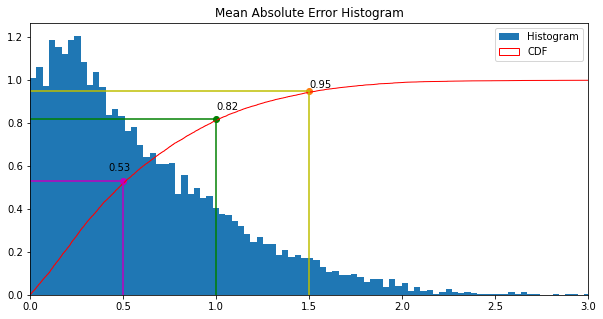

In [13]:
plt.figure(figsize=[10,5])
A = abs(np.array(group).mean(0)-y)*4
plt.hist(A,density=True,bins=100,label='Histogram')
plt.hist(A,density=True, cumulative=True, label='CDF', histtype='step',color='red',bins=10000)
plt.plot([1,1],[0,0.82],color='green')
plt.plot([0,1],[0.82,0.82],color='green')

plt.plot([0.5,0.5],[0,0.53],color='m')
plt.plot([0,0.5],[0.53,0.53],color='m')

plt.plot([1.5,1.5],[0,0.95],color='y')
plt.plot([0,1.5],[0.95,0.95],color='y')

plt.scatter([0.5],[0.53],color='m')
plt.annotate("0.53",[0.42,0.58])
plt.scatter([1],[0.82],color='green')
plt.annotate("0.82",[1,0.86])
plt.scatter([1.5],[0.95])
plt.annotate("0.95",[1.5,0.965])
plt.title("Mean Absolute Error Histogram")
plt.xlim([0, 3])
plt.legend()
plt.show()

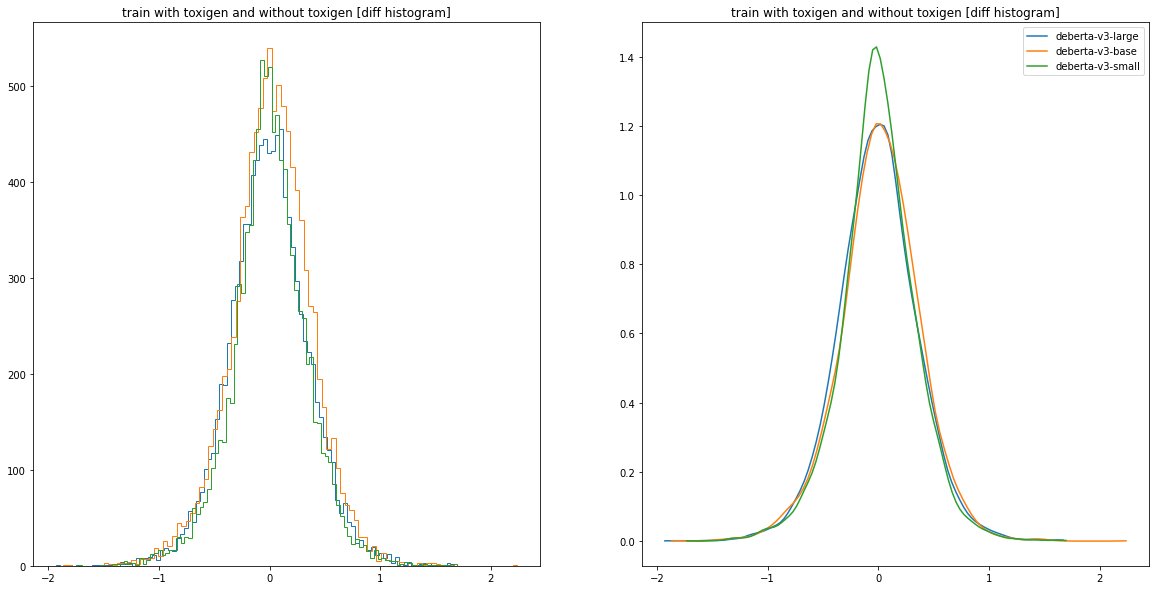

In [14]:
plt.figure(figsize=[20,10])
m0,m1 =2,15 
A = (np.array(group)[m0]-np.array(group)[m1])*4
density = stats.gaussian_kde(A)
plt.subplot(121)
n, x, _ = plt.hist(A,density=False,bins=100,label='deberta-v3-large',histtype=u'step')
plt.subplot(122)
plt.plot(x, density(x),label='deberta-v3-large')

m0,m1 =0,12 
A = (np.array(group)[m0]-np.array(group)[m1])*4
density = stats.gaussian_kde(A)
plt.subplot(121)
n, x, _ = plt.hist(A,density=False,bins=100,label='deberta-v3-base',histtype=u'step')
plt.subplot(122)
plt.plot(x, density(x),label='deberta-v3-base')


m0,m1 =4,16 
A = (np.array(group)[m0]-np.array(group)[m1])*4
density = stats.gaussian_kde(A)
plt.subplot(121)
n, x, _ = plt.hist(A,density=False,bins=100,label='deberta-v3-smal',histtype=u'step')
plt.title(f"train with toxigen and without toxigen [diff histogram]")
plt.subplot(122)
plt.plot(x, density(x),label='deberta-v3-small')

# # name0 = str(all_df2.iloc[m0]['exp']) + str(all_df2.iloc[m0]['type_mode'])
# # name1 = str(all_df2.iloc[m1]['exp']) + str(all_df2.iloc[m1]['type_mode'])
# # plt.title(f"{name0} - {name1} diff MAE histogram")
plt.title(f"train with toxigen and without toxigen [diff histogram]")
plt.legend()
plt.show()

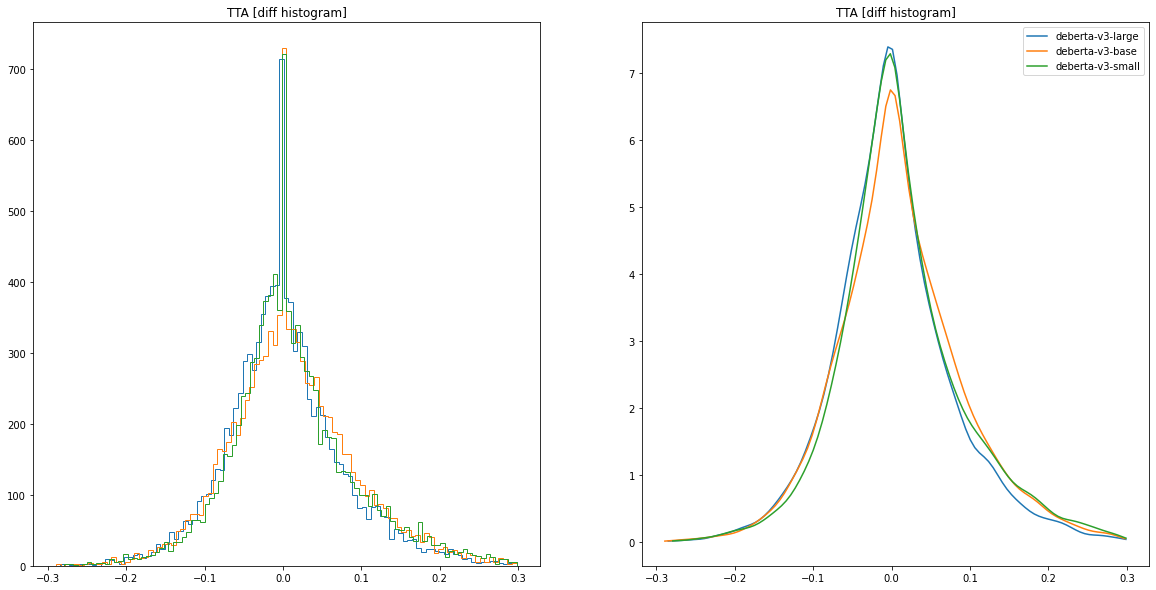

In [15]:
plt.figure(figsize=[20,10])
m0,m1 =2,3 
A = (np.array(group)[m0]-np.array(group)[m1])*4
density = stats.gaussian_kde(A)
plt.subplot(121)
n, x, _ = plt.hist(A,density=False,bins=100,label='deberta-v3-large',histtype=u'step')
plt.subplot(122)
plt.plot(x, density(x),label='deberta-v3-large')

m0,m1 =0,1 
A = (np.array(group)[m0]-np.array(group)[m1])*4
density = stats.gaussian_kde(A)
plt.subplot(121)
n, x, _ = plt.hist(A,density=False,bins=100,label='deberta-v3-base',histtype=u'step')
plt.subplot(122)
plt.plot(x, density(x),label='deberta-v3-base')


m0,m1 =4,5 
A = (np.array(group)[m0]-np.array(group)[m1])*4
density = stats.gaussian_kde(A)
plt.subplot(121)
n, x, _ = plt.hist(A,density=False,bins=100,label='deberta-v3-smal',histtype=u'step')
plt.title(f"TTA [diff histogram]")
plt.subplot(122)
plt.plot(x, density(x),label='deberta-v3-small')

# # name0 = str(all_df2.iloc[m0]['exp']) + str(all_df2.iloc[m0]['type_mode'])
# # name1 = str(all_df2.iloc[m1]['exp']) + str(all_df2.iloc[m1]['type_mode'])
# # plt.title(f"{name0} - {name1} diff MAE histogram")
plt.title(f"TTA [diff histogram]")
plt.legend()
plt.show()

In [16]:
all_df2

,mae,rmse,p_vlaue,r2,auc,average precision,model,TTA,type_mode,exp
0,0.631170,0.813313,0.0,0.548219,0.871360,0.747709,microsoft.deberta-v3-base,False,1,backtranslate
1,0.628966,0.808608,0.0,0.553431,0.871526,0.747595,microsoft.deberta-v3-base,True,1,backtranslate
2,0.610895,0.791094,0.0,0.572567,0.877974,0.764364,microsoft.deberta-v3-large,False,2,backtranslate
3,0.609688,0.786426,0.0,0.577595,0.878895,0.764814,microsoft.deberta-v3-large,True,2,backtranslate
4,0.637354,0.827276,0.0,0.532573,0.865620,0.742018,Narrativaai.deberta-v3-small-finetuned-hate_sp...,False,0,backtranslate
5,0.634767,0.820895,0.0,0.539757,0.866705,0.743775,Narrativaai.deberta-v3-small-finetuned-hate_sp...,True,0,backtranslate
6,0.641365,0.829058,0.0,0.530558,0.868100,0.742765,microsoft.deberta-v3-base,False,1,baseline
7,0.640207,0.824631,0.0,0.535558,0.867927,0.741005,microsoft.deberta-v3-base,True,1,baseline
8,0.618685,0.794058,0.0,0.569358,0.876919,0.762396,microsoft.deberta-v3-large,False,2,baseline
9,0.616964,0.790279,0.0,0.573446,0.877361,0.762272,microsoft.deberta-v3-large,True,2,baseline


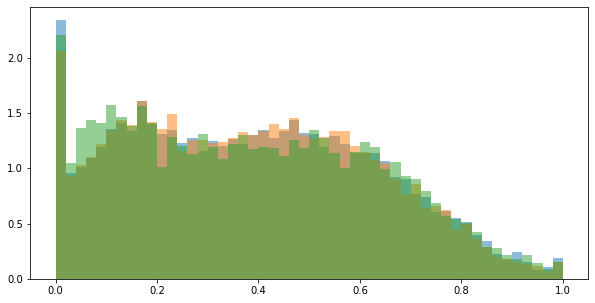

In [17]:
plt.figure(figsize=[10,5])
for g in group[0:3]:
    plt.hist(g*5,density=True,bins=50,alpha=0.5)


(array([ 18.,  53., 148., 309., 517., 684., 709., 484., 226.,  76.]),
 array([0.24159972, 0.61739819, 0.99319666, 1.36899513, 1.7447936 ,
        2.12059207, 2.49639054, 2.87218901, 3.24798748, 3.62378595,
        3.99958442]),
 <BarContainer object of 10 artists>)

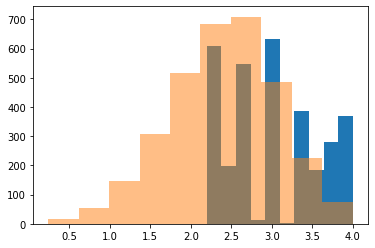

In [18]:
plt.hist(y[np.where(y*4>2)]*4)
plt.hist(np.array(group).mean(0)[np.where(y*4>2)]*4,alpha=0.5)

In [19]:
# plt.figure(figsize=[15,6])
# for i,(n,g) in enumerate(zip(Names,group)):
#     # if "baseline" in df_sum.reset_index(drop=True).iloc[i]['exp'].replace("outputs_","").replace("reg_",""):
#         display = PrecisionRecallDisplay.from_predictions((y>=0.5).astype(int),
#                                                           g,
#                                                           name = df_sum.reset_index(drop=True).iloc[i]['exp'].replace("outputs_","").replace("reg_","") +"-"+ df_sum.reset_index(drop=True).iloc[i]['type_mode']
#                                                           ,ax=plt.gca()
#                                                          )
# display = PrecisionRecallDisplay.from_predictions((y>=0.5).astype(int),
#                                                   np.array(group).mean(0),
#                                                   name = 'ensemble',ax=plt.gca()
#                                                  )
# _ = display.ax_.set_title("2-class Precision-Recall curve")

In [20]:
# from scipy import stats
# stats.friedmanchisquare(group1, group2, group3)

In [21]:
df = pd.concat(df_models).drop(["p_vlaue","type_mode"],1).astype(float)

In [22]:
df.to_csv("results.csv")

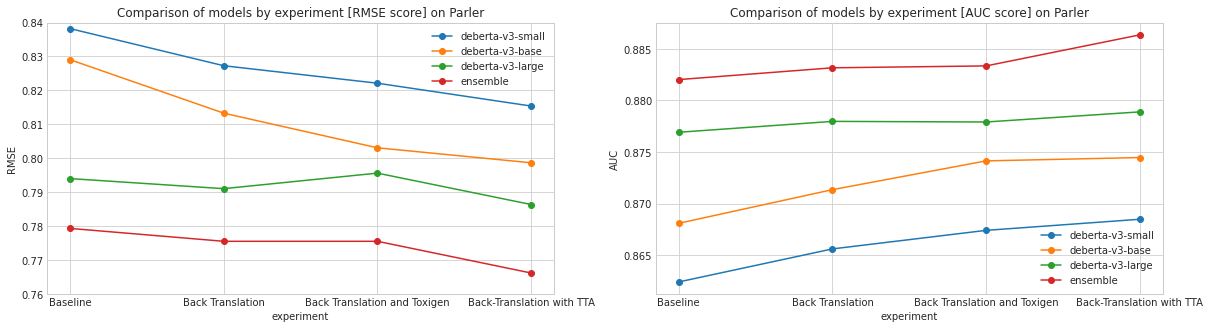

In [23]:
with plt.style.context("seaborn-whitegrid"):
    plt.figure(figsize=[20,5])
    plt.subplot(121)
    results_dict = {}
    results_dict['deberta-v3-small'] = [0.838207,0.827276,0.822131,0.815410]
    results_dict['deberta-v3-base'] = [0.829058,0.813313,0.803119,0.798712]
    results_dict['deberta-v3-large'] = [0.794058,0.791094,0.795665,0.786426]
    results_dict['ensemble'] = [0.779395,0.775601,0.775601,0.766266]

    for row in results_dict.keys():
        plt.plot(['Baseline', 'Back Translation', 'Back Translation and Toxigen', 'Back-Translation with TTA'],results_dict[row],label=row,marker="o")
        # plt.bar(["baseline","backtranslate",'toxigen and backtranslate','backtranslate with TTA'],results_dict[row])
    plt.legend()
    plt.title("Comparison of models by experiment [RMSE score] on Parler")
    plt.ylabel("RMSE")
    plt.xlabel("experiment")
    plt.ylim([0.76,0.84])

    results_dict = {}
    results_dict['deberta-v3-small'] = [0.862419,0.865620,0.867417,0.868492]
    results_dict['deberta-v3-base'] = [0.868100,0.871360,0.874147,0.874471]
    results_dict['deberta-v3-large'] = [0.876919,0.877974,0.877914,0.878895]
    results_dict['ensemble'] = [0.882022,0.883164,0.883348,0.886356]
    # plt.figure(figsize=[10,6])
    plt.subplot(122)
    for row in results_dict.keys():
        plt.plot(['Baseline', 'Back Translation', 'Back Translation and Toxigen', 'Back-Translation with TTA'],results_dict[row],label=row,marker="o")
    plt.legend()
    plt.title("Comparison of models by experiment [AUC score] on Parler")
    plt.ylabel("AUC")
    plt.xlabel("experiment")

    plt.show()

0    Narrativaai.deberta-v3-small-finetuned-hate_sp...
2    Narrativaai.deberta-v3-small-finetuned-hate_sp...
4    Narrativaai.deberta-v3-small-finetuned-hate_sp...
Name: model, dtype: object
Narrativaai.deberta-v3-small-finetuned-hate_speech18
ensemble
0    microsoft.deberta-v3-base
2    microsoft.deberta-v3-base
4    microsoft.deberta-v3-base
Name: model, dtype: object
microsoft.deberta-v3-base
0    microsoft.deberta-v3-large
2    microsoft.deberta-v3-large
4    microsoft.deberta-v3-large
Name: model, dtype: object
microsoft.deberta-v3-large


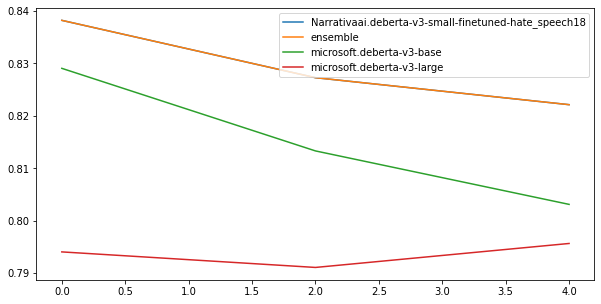

In [24]:
plt.figure(figsize=[10,5])
for index,mini in df.groupby("model"):
    mini = mini.reset_index()
    if index == 'ensemble':
        plt.plot(m['rmse'],label='ensemble')
        print(index)
        continue
    m = mini[mini['TTA']==False]
    print(m['model'])
    plt.plot(m['rmse'],label=index)
    print(index)
plt.legend()

In [25]:
mini

,model,exp,TTA,mae,rmse,r2,auc,average precision
0,microsoft.deberta-v3-large,baseline,False,0.618685,0.794058,0.569358,0.876919,0.762396
1,microsoft.deberta-v3-large,baseline,True,0.616964,0.790279,0.573446,0.877361,0.762272
2,microsoft.deberta-v3-large,backtranslate,False,0.610895,0.791094,0.572567,0.877974,0.764364
3,microsoft.deberta-v3-large,backtranslate,True,0.609688,0.786426,0.577595,0.878895,0.764814
4,microsoft.deberta-v3-large,toxigen_backtranslate,False,0.618256,0.795665,0.567613,0.877914,0.765074
5,microsoft.deberta-v3-large,toxigen_backtranslate,True,0.617572,0.791518,0.572109,0.878303,0.764830


In [26]:
m0,m1 =0,12 
A = (np.array(group)[m0]-np.array(group)[m1])*4

In [27]:
abs(A).mean()

0.2789398424088803

In [28]:
A.std()

0.3625118647926875

In [29]:
from scipy import stats
stats.friedmanchisquare(np.array(group)[m0], np.array(group)[m1], y)

FriedmanchisquareResult(statistic=79.56559978012456, pvalue=5.278974122347685e-18)

outputs_baseline_reg/microsoft.deberta-v3-base/oof_df.pkl outputs_toxigen_backtranslate_reg/microsoft.deberta-v3-base/oof_df.pkl outputs_toxigen_backtranslate_reg/microsoft.deberta-v3-base/tta.pkl
RMSE on a bias_afro_parler without BT  0.8878958847973734
RMSE on a bias_afro_parler with BT  0.8607723810094571
RMSE on a bias_afro_parler with BT and TTA  0.8349737825288228
avg results on model that train without BT  3.148012479910484
avg results on model that train with BT  2.896741107106209
avg results on model that train with BT and TTA 2.9064422868765316


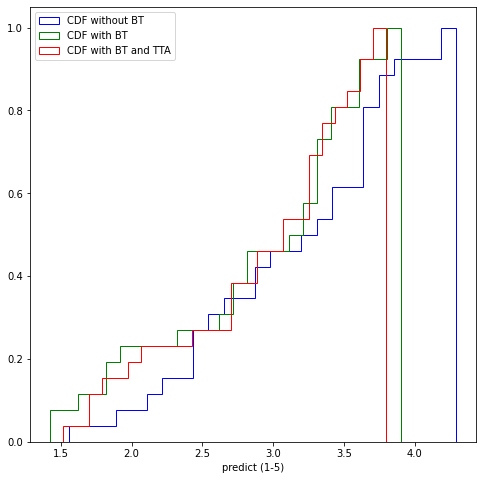

In [30]:
df_bais = pd.read_csv("bias_afro_parler.csv")
pkl = [row for row in glob.glob("outputs_baseline_reg/*/*.pkl") if "_reg" in row and "unitary" not in row]
pkl2 = [row for row in glob.glob("outputs_toxigen_backtranslate_reg/*/*.pkl") if "_reg" in row and "unitary" not in row]
df0 = pd.read_pickle(pkl[0])
df1 = pd.read_pickle(pkl2[0])
df2 = pd.read_pickle(pkl2[1])
print(pkl[0],pkl2[0],pkl2[1])
res = []
res_bt = []
res_bt_tta = []
for row in df_bais["id"]:
    pred_label_mean_with_out_bt = df0[df0['id']==row]['pred_label_mean'].values[0]*4+1
    pred_label_mean_with_bt = df1[df1['id']==row]['pred_label_mean'].values[0]*4+1
    pred_label_mean_with_bt_tta = df2[df2['id']==row]['pred_label_mean'].values[0]*4+1
    res.append(pred_label_mean_with_out_bt)
    res_bt.append(pred_label_mean_with_bt)
    res_bt_tta.append(pred_label_mean_with_bt_tta)
df_bais['pred_label_mean_without_bt'] = res
df_bais['pred_label_mean_with_bt'] = res_bt
df_bais['pred_label_mean_with_bt_tta'] = res_bt_tta
print("RMSE on a bias_afro_parler without BT ",np.sqrt(mean_squared_error(res,df_bais["label_mean"])))
print("RMSE on a bias_afro_parler with BT ",np.sqrt(mean_squared_error(res_bt,df_bais["label_mean"])))
print("RMSE on a bias_afro_parler with BT and TTA ",np.sqrt(mean_squared_error(res_bt_tta,df_bais["label_mean"])))
print("avg results on model that train without BT ", np.mean(res))
print("avg results on model that train with BT ", np.mean(res_bt))
print("avg results on model that train with BT and TTA", np.mean(res_bt_tta))
plt.figure(figsize=[8,8])
# plt.hist(res,density=True,bins=10,label='Histogram without BT',color='blue')
plt.hist(res,density=True, cumulative=True, label='CDF without BT', histtype='step',color='blue',bins=25)
# plt.hist(res_bt,density=True,bins=10,label='Histogram with BT',alpha=0.5,color='green')
plt.hist(res_bt,density=True, cumulative=True, label='CDF with BT', histtype='step',color='green',bins=25)
# plt.hist(res_bt_tta,density=True,bins=10,label='Histogram with BT and TTA',alpha=0.3,color='red')
plt.hist(res_bt_tta,density=True, cumulative=True, label='CDF with BT and TTA', histtype='step',color='red',bins=25)
plt.xlabel("predict (1-5)")
plt.legend(loc='upper left')
df_bais.to_csv('res_bais.csv',index=False)

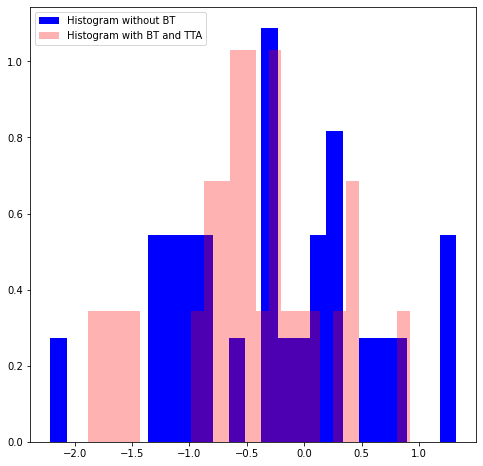

In [38]:
plt.figure(figsize=[8,8])
plt.hist(res-df_bais["label_mean"],density=True,bins=25,label='Histogram without BT',color='blue')
# plt.hist(res,density=True, cumulative=True, label='CDF without BT', histtype='step',color='blue',bins=25)
# plt.hist(res_bt-df_bais["label_mean"],density=True,bins=25,label='Histogram with BT',alpha=0.5,color='green')
# plt.hist(res_bt,density=True, cumulative=True, label='CDF with BT', histtype='step',color='green',bins=25)
plt.hist(res_bt_tta-df_bais["label_mean"],density=True,bins=25,label='Histogram with BT and TTA',alpha=0.3,color='red')
# plt.hist(res_bt_tta,density=True, cumulative=True, label='CDF with BT and TTA', histtype='step',color='red',bins=25)
# plt.xlabel("predict (1-5)")
plt.legend(loc='upper left')